# **Disciplina CAT010** - Aplicações dos Satélites em Ciências Atmosféricas


---






## **Aula Prática 6:** $\underline{Analisando\ Dados\ de\ Índice\ de\ Vegetação\ (NDVI)}$
---
**OBJETIVO:** Neste Google Colab aprenderemos como gerar e analisar mapas de  *Normalized Difference Vegetation Index* (NDVI) estimado por satélite de órbita polar. Serão utilizados os dados do sensor [Visible/Infrared Imager Radiometer Suite(VIIRS)](https://space.oscar.wmo.int/instruments/view/viirs) que esta abordo do satélite [Suomi National Polar-orbiting Partnership (SNPP)](https://space.oscar.wmo.int/satellites/view/snpp). Iremos utilizar os dados fornecidos pela [NOAA](https://www.ncei.noaa.gov/metadata/geoportal/rest/metadata/item/gov.noaa.ncdc:C01558/html) em seu  [repositório](https://www.ncei.noaa.gov/data/avhrr-land-normalized-difference-vegetation-index/access).

---


**DADOS DE ENTRADA**: Arquivos de NDVI de satélite polar.

- **Tipo do dado:** matriz de 3600 linhas x 7200 colunas  
- **Formato do dado:** arquivo NETCDF
- **Nome do arquivo:** VIIRS-Land_v001-preliminary_NPP13C1_S-NPP_20200102_c20220419001202.nc
- **Fonte dos dados:** FTP da [NOAA](https://www.ncei.noaa.gov/data/avhrr-land-normalized-difference-vegetation-index/access)


---


**DADOS DE SAÍDA:** Mapas de NDVI.
- **Tipo do dado:** Figura
- **Formato do dado:** arquivos JPG
- **Imagens geradas:**
    1. Fig_1_ndvi_global_diario_20200208.jpg
    2. Fig_2_ndvi_SA_diario_20200208.jpg
    3. Fig_3_ndvi_global_mensal_202002.jpg
    4. Fig_4_ndvi_SA_mensal_202002.jpg
    5. Fig_5_ndvi_global_anual_2020.jpg
    6. Fig_6_ndvi_SA_anual_2020.jpg

---

**METODOLOGIA:** Serão abordados os seguintes tópicos:

1.   Como baixar os dados de NDVI.
2.   Como plotar o mapa espacial de NDVI para um dia.
3.   Como plotar o mapa espacial médio de NDVI para um mês.
4.   Como plotar o mapa espacial médio de NDVI para um ano.

---

**PROCEDIMENTO REALIZADO:** Os seguintes procedimentos são realizados nesse código:
1.   Instalação de bibliotecas
2.   Monta o google drive
3.   Define o caminho do google drive
4.   Importação das bibliotecas
5.   Download dos shapefiles
6.   Informa o ano de processamento
7.   Baixa os dados
8.   Gera o dataset com todos arquivos
9.   Plota NDVI diário
10.  Plota NDVI mensal
11.  Plota NDVI anual


---
**OBSERVAÇÕES IMPORTANTES**:
1. Fazer mudanças, veja em: **### >>> MUDANÇAS AQUI <<< ###**
    - 1. Caminho do seu drive

---
- **Realizado por:** Enrique V. Mattos - 23/08/2022
- **Atualizado por:** Enrique V. Mattos - 13/11/2023


---

# **1° Passo:** Instalando as bibliotecas

In [ ]:
# Instalando o proplot (usado para gerar Mapas também)
!pip install -q proplot

# Instalando o cartopy (usado para gerar Mapas)
!pip uninstall shapely --yes
!pip install -q shapely cartopy==0.21.1 --no-binary shapely --no-binary cartopy
!wget https://raw.githubusercontent.com/SciTools/cartopy/master/tools/cartopy_feature_download.py
!python cartopy_feature_download.py physical

In [ ]:
# Instalando a biblioteca Salem
!pip install -q rasterio pyproj geopandas salem descartes

Chegando aqui, será necessário fazer a **Reinicialização do Ambiente de Execução** (acessar *Ambiente de execução* que esta na barra de ferramentas e clicar em *Reiniciar Ambiente de Execução* e rodar novamente a célula anterior de instalações) e ter que instalar todos os pacotes de novo. Isso é necessário tanto para poder usar sem problemas o `Proplot` quanto o `CartoPy` na nossa sessão do Colab, então a partir desse ponto não teremos mais que nos preocupar com a preparação do ambiente virtual.

# **2° Passo:** Montando drive

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **3° Passo:** Caminho do diretório - **### >>> MUDANÇAS AQUI <<< ###**
- Insira aqui o caminho da pasta do seu Google Drive onde esta o código dessa aula.

In [5]:
dir = '/content/drive/MyDrive/00_DISPONIBILIZAÇÃO_DE_AULAS/2_SEGUNDO_SEMESTRE/CAT010 - APLICAÇÕES DOS SATÉLITES EM CIÊNCIAS ATMOSFÉRICAS/AULAS/CAT010 - PYTHON PARA SATÉLITES METEOROLÓGICOS/AULA_06_NDVI/'

- cria a pasta output

In [7]:
import os
os.makedirs(f'{dir}output/', exist_ok=True)

# **4° Passo:** Importando as bibliotecas

In [14]:
from bs4 import BeautifulSoup
import requests
import xarray as xr
import proplot as plot
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook
import time
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm
import glob
import salem

import sys
sys.path.append(f'{dir}')
from cpt_convert import loadCPT

import warnings
warnings.filterwarnings("ignore")

# **5° Passo:** Shapefiles
- Iremos utilizar os arquivos shapefiles do território brasileiro. Os dados serão baixados direto do meu [GitHub](https://github.com/evmpython/shapefile).

In [15]:
# url
url = 'https://github.com/evmpython/shapefile/raw/main/'

# caminho completo do arquivo. Exemplo: !wget https://github.com/evmpython/shapefile/raw/main/BR_UF_2019.shp
file1 = f'{url}BR_UF_2019.cpg'
file2 = f'{url}BR_UF_2019.dbf'
file3 = f'{url}BR_UF_2019.prj'
file4 = f'{url}BR_UF_2019.shp'
file5 = f'{url}BR_UF_2019.shx'

# baixa o shapefile
!wget -c {file1}
!wget -c {file2}
!wget -c {file3}
!wget -c {file4}
!wget -c {file5}

# lendo shapefile de todos Estados do Brasil
estados = salem.read_shapefile('/content/BR_UF_2019.shp')
estados

--2023-11-13 18:38:04--  https://github.com/evmpython/shapefile/raw/main/BR_UF_2019.cpg
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/evmpython/shapefile/main/BR_UF_2019.cpg [following]
--2023-11-13 18:38:04--  https://raw.githubusercontent.com/evmpython/shapefile/main/BR_UF_2019.cpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 416 Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

--2023-11-13 18:38:04--  https://github.com/evmpython/shapefile/raw/main/BR_UF_2019.dbf
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443.

CD_UF                NM_UF SIGLA_UF     NM_REGIAO  \
0     11             Rondônia       RO         Norte   
1     12                 Acre       AC         Norte   
2     13             Amazonas       AM         Norte   
3     14              Roraima       RR         Norte   
4     15                 Pará       PA         Norte   
5     16                Amapá       AP         Norte   
6     17            Tocantins       TO         Norte   
7     21             Maranhão       MA      Nordeste   
8     22                Piauí       PI      Nordeste   
9     23                Ceará       CE      Nordeste   
10    24  Rio Grande do Norte       RN      Nordeste   
11    25              Paraíba       PB      Nordeste   
12    26           Pernambuco       PE      Nordeste   
13    27              Alagoas       AL      Nordeste   
14    28              Sergipe       SE      Nordeste   
15    29                Bahia       BA      Nordeste   
16    31         Minas Gerais       MG       Sudeste   
17    32       Espírito Santo       ES       Sudeste   
18    33       Rio de Janeiro       RJ       Sudeste   
19    35            São Paulo       SP       Sudeste   
20    41               Paraná       PR           Sul   
21    42       Santa Catarina       SC           Sul   
22    43    Rio Grande do Sul       RS           Sul   
23    50   Mato Grosso do Sul       MS  Centro-oeste   
24    51          Mato Grosso       MT  Centro-oeste   
25    52                Goiás       GO  Centro-oeste   
26    53     Distrito Federal       DF  Centro-oeste   

                                             geometry      min_x      max_x  \
0   POLYGON ((-65.38150 -10.42907, -65.38013 -10.4... -66.810253 -59.774357   
1   POLYGON ((-71.07772 -9.82774, -71.07817 -9.828... -73.990450 -66.623754   
2   POLYGON ((-69.83766 -3.68659, -69.82555 -3.620... -73.801558 -56.097558   
3   POLYGON ((-63.96008 2.47313, -63.96041 2.47416... -64.825254 -58.886884   
4   MULTIPOLYGON (((-51.43248 -0.47334, -51.42949 ... -58.898328 -46.061425   
5   MULTIPOLYGON (((-50.45011 2.10924, -50.44715 2... -54.876250 -49.875682   
6   POLYGON ((-48.23163 -5.94614, -48.23011 -5.938... -50.742064 -45.699265   
7   MULTIPOLYGON (((-44.53830 -2.02124, -44.53742 ... -48.755151 -41.795884   
8   POLYGON ((-42.91539 -6.64607, -42.91645 -6.644... -46.028207 -40.370510   
9   POLYGON ((-41.18292 -4.01797, -41.18552 -4.017... -41.423518 -37.252659   
10  MULTIPOLYGON (((-37.04412 -4.81854, -37.04501 ... -38.582099 -34.968454   
11  MULTIPOLYGON (((-34.79576 -7.35000, -34.79601 ... -38.765603 -34.793086   
12  MULTIPOLYGON (((-32.39240 -3.82372, -32.39253 ... -41.358336 -32.377768   
13  MULTIPOLYGON (((-35.75791 -9.69285, -35.75801 ... -38.237590 -35.151892   
14  MULTIPOLYGON (((-36.91665 -10.84277, -36.91681... -38.245009 -36.396329   
15  MULTIPOLYGON (((-38.69616 -17.97901, -38.69618... -46.577285 -37.341147   
16  POLYGON ((-50.74208 -19.21384, -50.74241 -19.2... -51.046082 -39.856829   
17  MULTIPOLYGON (((-40.75189 -20.92722, -40.75193... -41.879796 -28.847640   
18  MULTIPOLYGON (((-41.82923 -22.78453, -41.82939... -44.889321 -40.957941   
19  MULTIPOLYGON (((-48.03716 -25.35794, -48.03750... -53.110112 -44.161365   
20  MULTIPOLYGON (((-48.40736 -25.84270, -48.40750... -54.620213 -48.023537   
21  MULTIPOLYGON (((-48.60084 -28.35222, -48.60096... -53.837149 -48.327875   
22  MULTIPOLYGON (((-49.70392 -29.34774, -49.70402... -57.649743 -49.691352   
23  POLYGON ((-57.83371 -20.93628, -57.83553 -20.9... -58.168512 -50.922909   
24  POLYGON ((-52.61926 -9.68225, -52.60224 -9.683... -61.633383 -50.224806   
25  POLYGON ((-52.36102 -16.08160, -52.36040 -16.0... -53.248562 -45.907155   
26  POLYGON ((-47.81455 -16.04995, -47.81478 -16.0... -48.285828 -47.308406   

        min_y      max_y  
0  -13.693700  -7.975868  
1  -11.145561  -7.111824  
2   -9.818046   2.246631  
3   -1.580633   5.271841  
4   -9.841153   2.591027  
5   -1.236176   4.508817  
6  -13.467713  -5.168381  
7  -1

# **PARTE 1):** Informando a data da imagem - **### >>> MUDANÇAS AQUI <<< ###**

- Iremos baixar e analisar os dados de NDVI para um ano específico. No exemplo a seguir faremos uma análise para o ano de **2022**. Porém, você pode alterar para o ano que desejar.

In [18]:
ano = '2022'

# **PARTE 2):**  Baixando os arquivos de NDVI
- Nesta etapa iremos baixar todos os arquivos de NDVI do ano de 2022. Os arquivos estão disponiveis no [FTP](https://www.ncei.noaa.gov/data/avhrr-land-normalized-difference-vegetation-index/access/2020/) da NOAA. Os dados estão em pasta por ano. Ao acessar a pasta de 2022, o aluno terá acesso aos dados do ano todo de 2022. Existe um arquivo para cada dia. Veja exemplo na imagem a seguir:

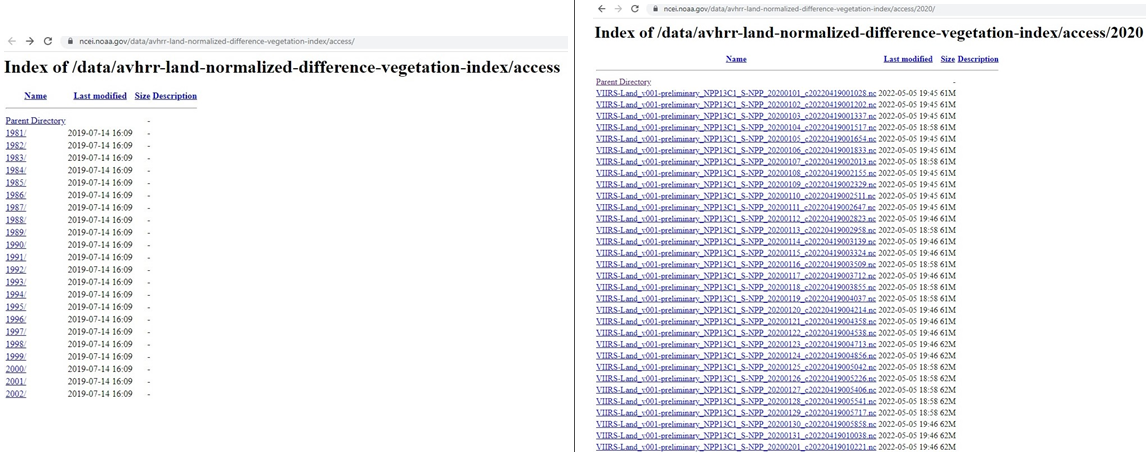

**Site da NOAA com os dados de NDVI**

In [19]:
# link do site dos dados da NOAA
url = f'ncei.noaa.gov/data/avhrr-land-normalized-difference-vegetation-index/access/{ano}/'

# extensão dos arquivos netcdf
ext = 'nc'

# caminho completo dos arquivos
url = 'http://' + url

**Função que baixa os dados**

In [20]:
# função que baixa os dados
def listFD(url, ext=''):

    page = requests.get(url).text

    soup = BeautifulSoup(page, 'html.parser')

    return [url + '/' + node.get('href') for node in soup.find_all('a') if node.get('href').endswith(ext)]

**Baixando os dados**
- Os dados serão baixados para a máquina virtual do Google. Demora 37 min para baixar os dados de 1 ano completo. Veja exemplo na imagem a seguir:

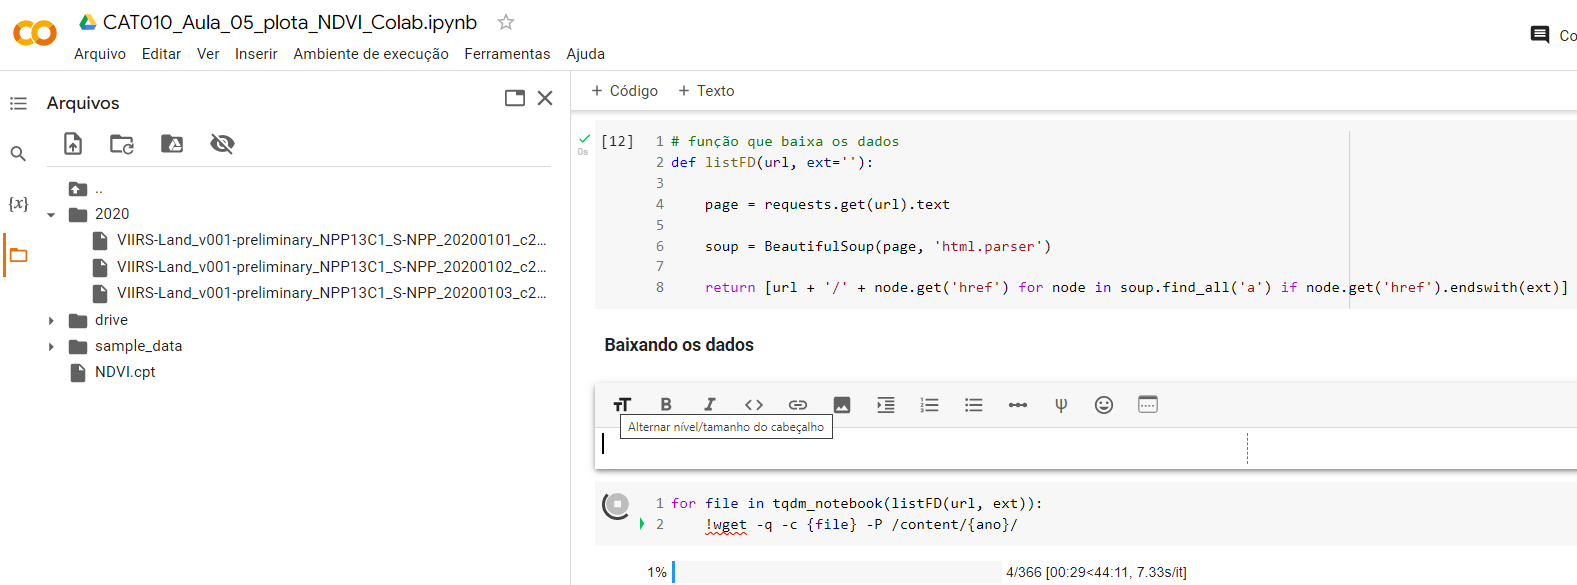

In [21]:
# demora 1 h para baixar um ano de dados
for file in tqdm_notebook(listFD(url, ext)):
    !wget -q -c {file} -P /content/{ano}/

  0%|          | 0/349 [00:00<?, ?it/s]

Exemplo do nome do arquivo que foi baixado: **VIIRS-Land_v001-preliminary_NPP13C1_S-NPP_20200101_c20220419001028.nc**

# **PARTE 3):** Gerando um único Dataset
- Iremos ler os arquivos do ano todo de uma única vez, e produziremos um único conjunto de dados. Para isto usaremos mais uma vez a biblioteca [**xarray**](https://docs.xarray.dev/en/stable/) com a função [**open_mf_dataset**](https://docs.xarray.dev/en/stable/generated/xarray.open_mfdataset.html).

In [22]:
# lista dos arquivos que foram baixados. Exemplo: VIIRS-Land_v001-preliminary_NPP13C1_S-NPP_20220101_c20220419212429.nc
files_ndvi = sorted(glob.glob(f'/content/{ano}/VIIRS-Land_v001-preliminary_NPP13C1_S-NPP_{ano}*.nc'))

In [23]:
# exibe os nomes dos arquivos
files_ndvi

['/content/2022/VIIRS-Land_v001-preliminary_NPP13C1_S-NPP_20220101_c20220419212429.nc',
 '/content/2022/VIIRS-Land_v001-preliminary_NPP13C1_S-NPP_20220102_c20220419212611.nc',
 '/content/2022/VIIRS-Land_v001-preliminary_NPP13C1_S-NPP_20220103_c20220419212750.nc',
 '/content/2022/VIIRS-Land_v001-preliminary_NPP13C1_S-NPP_20220104_c20220419212926.nc',
 '/content/2022/VIIRS-Land_v001-preliminary_NPP13C1_S-NPP_20220105_c20220419213101.nc',
 '/content/2022/VIIRS-Land_v001-preliminary_NPP13C1_S-NPP_20220106_c20220419213232.nc',
 '/content/2022/VIIRS-Land_v001-preliminary_NPP13C1_S-NPP_20220107_c20220419213413.nc',
 '/content/2022/VIIRS-Land_v001-preliminary_NPP13C1_S-NPP_20220108_c20220419213558.nc',
 '/content/2022/VIIRS-Land_v001-preliminary_NPP13C1_S-NPP_20220109_c20220419213734.nc',
 '/content/2022/VIIRS-Land_v001-preliminary_NPP13C1_S-NPP_20220110_c20220419213917.nc',
 '/content/2022/VIIRS-Land_v001-preliminary_NPP13C1_S-NPP_20220111_c20220419214057.nc',
 '/content/2022/VIIRS-Land_v001-

In [24]:
# lendo os dados
ndvi = xr.open_mfdataset(files_ndvi, concat_dim='time', combine='nested')

In [25]:
# mostrando os dados
ndvi

<xarray.Dataset>
Dimensions:    (latitude: 3600, longitude: 7200, time: 348, ncrs: 1, nv: 2)
Coordinates:
  * latitude   (latitude) float32 89.97 89.93 89.88 ... -89.88 -89.93 -89.97
  * longitude  (longitude) float32 -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
  * time       (time) datetime64[ns] 2022-01-01 2022-01-02 ... 2022-12-31
Dimensions without coordinates: ncrs, nv
Data variables:
    crs        (time, ncrs) int16 dask.array<chunksize=(1, 1), meta=np.ndarray>
    lat_bnds   (time, latitude, nv) float32 dask.array<chunksize=(1, 3600, 2), meta=np.ndarray>
    lon_bnds   (time, longitude, nv) float32 dask.array<chunksize=(1, 7200, 2), meta=np.ndarray>
    NDVI       (time, latitude, longitude) float32 dask.array<chunksize=(1, 3600, 7200), meta=np.ndarray>
    TIMEOFDAY  (time, latitude, longitude) datetime64[ns] dask.array<chunksize=(1, 3600, 7200), meta=np.ndarray>
    QA         (time, latitude, longitude) int16 dask.array<chunksize=(1, 3600, 7200), meta=np.ndarray>
Attributes: (12/44)
    title:                             Normalized Difference Vegetation Index...
    institution:                       NASA/GSFC/SED/ESD/HBSL/TIS/MODIS-LAND ...
    Conventions:                       CF-1.6, ACDD-1.3
    standard_name_vocabulary:          CF Standard Name Table (v25, 05 July 2...
    naming_authority:                  gov.noaa.ncei
    license:                           See the Use Agreement for this CDR ava...
    ...                                ...
    LocalGranuleID:                    VIIRS-Land_v001-preliminary_NPP13C1_S-...
    id:                                VIIRS-Land_v001-preliminary_NPP13C1_S-...
    RangeBeginningDate:                2022-01-01
    RangeBeginningTime:                00:00:00.0000
    RangeEndingDate:                   2022-01-01
    RangeEndingTime:                   23:59:59.9999

In [26]:
# mostrando as longitudes
ndvi['longitude']

<xarray.DataArray 'longitude' (longitude: 7200)>
array([-179.975  , -179.925  , -179.875  , ...,  179.875  ,  179.92499,
        179.975  ], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
Attributes:
    units:          degrees_east
    long_name:      longitude
    axis:           X
    standard_name:  longitude
    bounds:         lon_bnds

In [27]:
# mostrando as latitudes
ndvi['latitude']

<xarray.DataArray 'latitude' (latitude: 3600)>
array([ 89.975  ,  89.925  ,  89.875  , ..., -89.875  , -89.925  , -89.97499],
      dtype=float32)
Coordinates:
  * latitude  (latitude) float32 89.97 89.93 89.88 ... -89.88 -89.93 -89.97
Attributes:
    units:          degrees_north
    long_name:      latitude
    axis:           Y
    standard_name:  latitude
    bounds:         lat_bnds

In [28]:
# mostrando os tempos
ndvi['time']

<xarray.DataArray 'time' (time: 348)>
array(['2022-01-01T00:00:00.000000000', '2022-01-02T00:00:00.000000000',
       '2022-01-03T00:00:00.000000000', ..., '2022-12-29T00:00:00.000000000',
       '2022-12-30T00:00:00.000000000', '2022-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2022-01-01 2022-01-02 ... 2022-12-31
Attributes:
    long_name:      time
    axis:           T
    standard_name:  time

# **PARTE 4):** Plotando NDVI `DIÁRIO`
- Nesta etapa iremos gerar o mapa de NDVI para um determinado **dia**. Então você deverá escolher um **mês** e **dia** no bloco a seguir.

**define o mês e ano a ser plotado** - **### >>> MUDANÇAS AQUI <<< ###**

In [29]:
mes = '02'  # mês a ser processado
dia = '08'  # dia a ser processado

**seleciona o tempo**

In [30]:
# define o tempo
tempo = f'{ano}-{mes}-{dia}T00:00:00.000000000'

In [31]:
# mostra o nome do tempo
print(tempo)

2022-02-08T00:00:00.000000000


In [32]:
# seleciona o arquivo de NDVI daquele dia
ndvi_dia = ndvi['NDVI'].loc[tempo]

**exibe na tela o arquivo selecionado daquele dia**

In [33]:
ndvi_dia

<xarray.DataArray 'NDVI' (latitude: 3600, longitude: 7200)>
dask.array<getitem, shape=(3600, 7200), dtype=float32, chunksize=(3600, 7200), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 89.97 89.93 89.88 ... -89.88 -89.93 -89.97
  * longitude  (longitude) float32 -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
    time       datetime64[ns] 2022-02-08
Attributes:
    long_name:      NOAA Climate Data Record of Normalized Difference Vegetat...
    units:          1
    valid_range:    [-1000 10000]
    grid_mapping:   crs
    standard_name:  normalized_difference_vegetation_index

## **a) plotando figura `DIÁRIA` global**

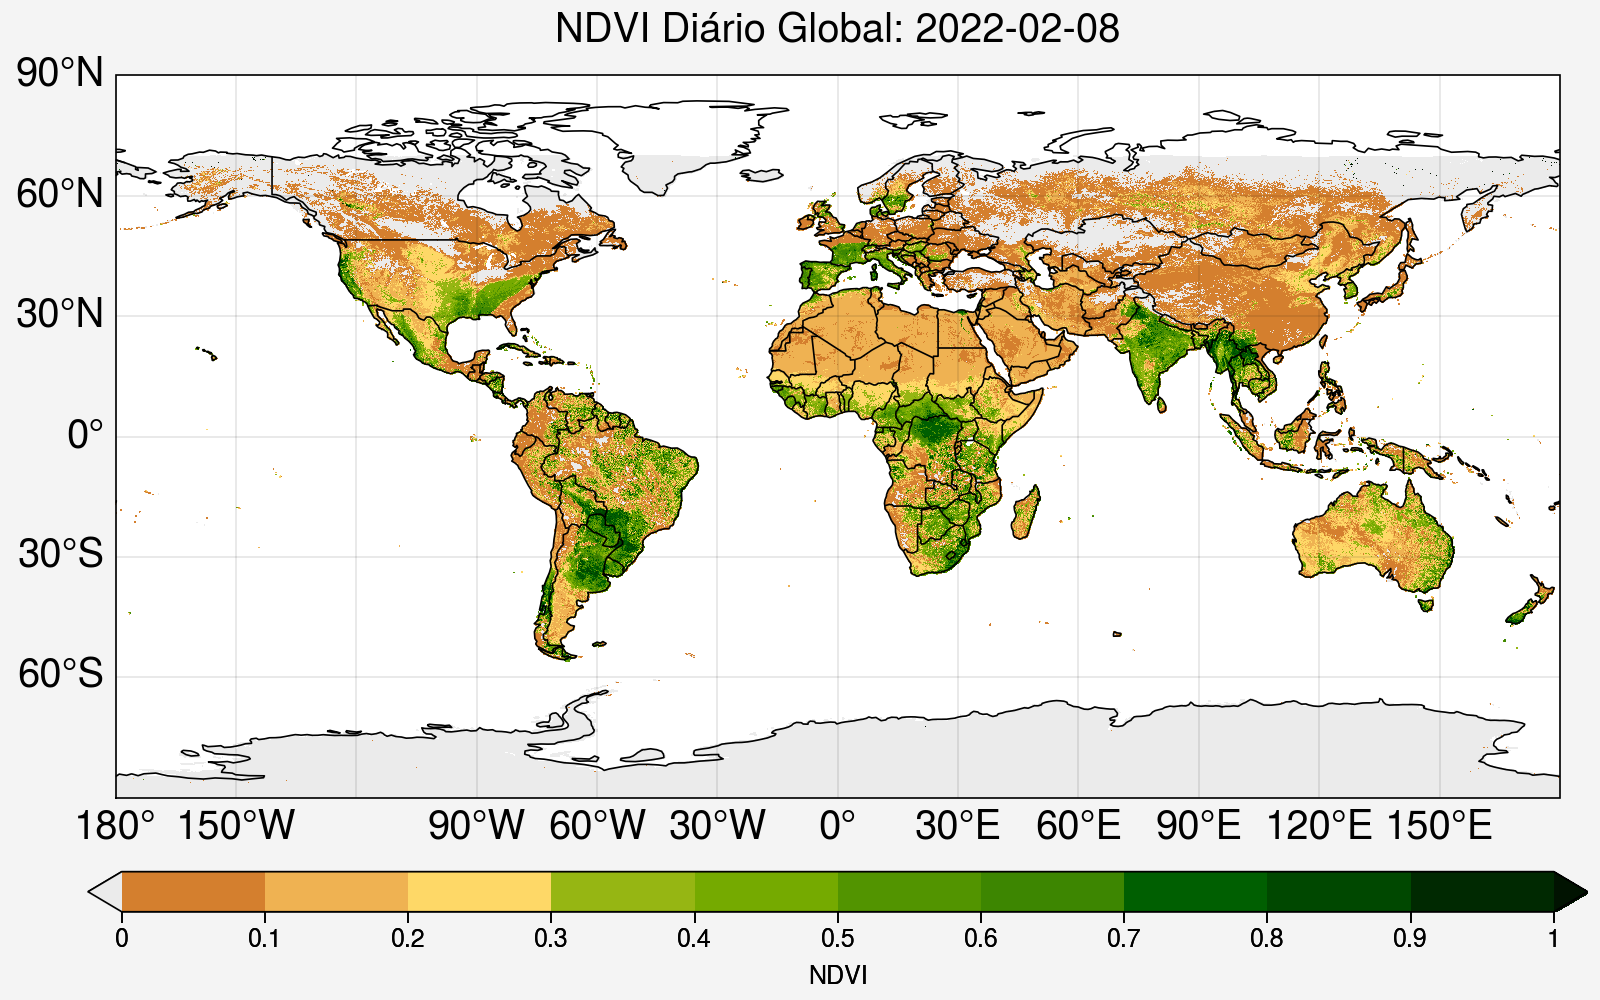

In [34]:
# moldura da figura
fig, ax = plot.subplots(figsize=(8, 5), tight=True, proj='pcarree')

# formatação dos eixos
ax.format(coast=True, borders=True, innerborders=False,
          labels=True, latlines=30, lonlines=30,
          title=f'NDVI Diário Global: {ano}-{mes}-{dia}', small='20px', large='20px')

# carrega tabela de cores
cpt_ndvi = loadCPT(f'{dir}NDVI.cpt')
cpt_convert_ndvi = LinearSegmentedColormap('cpt_ndvi', cpt_ndvi)

# valores mínimo e máximo de NDVI
vmin_ndvi = 0
vmax_ndvi = 1

# plota figura
map1 = ax.pcolormesh(ndvi_dia['longitude'],
                     ndvi_dia['latitude'],
                     ndvi_dia[:,:],
                     vmin=vmin_ndvi,
                     vmax=vmax_ndvi,
                     cmap=cpt_convert_ndvi,
                     levels=plot.arange(vmin_ndvi, vmax_ndvi, 0.1),
                     extend='both')

# plota barra de cores
fig.colorbar(map1, loc='b', label='NDVI')

# salva figura
fig.save(f'{dir}output/Fig_1_ndvi_global_diario_{ano}{mes}{dia}.jpg', dpi=300)

## **a) plotando figura `DIÁRIA` setorizada**

**Faz o recorte para a América do Sul**

In [35]:
# define a região de recorte
lonmin_AS, lonmax_AS, latmin_AS, latmax_AS = -85, -31, -59, 15

In [36]:
# faz o recorte
ndvi_dia_rec = ndvi_dia.sel(longitude=slice(lonmin_AS, lonmax_AS), latitude=slice(latmax_AS, latmin_AS))

In [37]:
# mostra o dado recortado
ndvi_dia_rec

<xarray.DataArray 'NDVI' (latitude: 1480, longitude: 1080)>
dask.array<getitem, shape=(1480, 1080), dtype=float32, chunksize=(1480, 1080), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 14.97 14.92 14.88 ... -58.88 -58.93 -58.97
  * longitude  (longitude) float32 -84.97 -84.92 -84.88 ... -31.12 -31.07 -31.03
    time       datetime64[ns] 2022-02-08
Attributes:
    long_name:      NOAA Climate Data Record of Normalized Difference Vegetat...
    units:          1
    valid_range:    [-1000 10000]
    grid_mapping:   crs
    standard_name:  normalized_difference_vegetation_index

**Plota a figura**

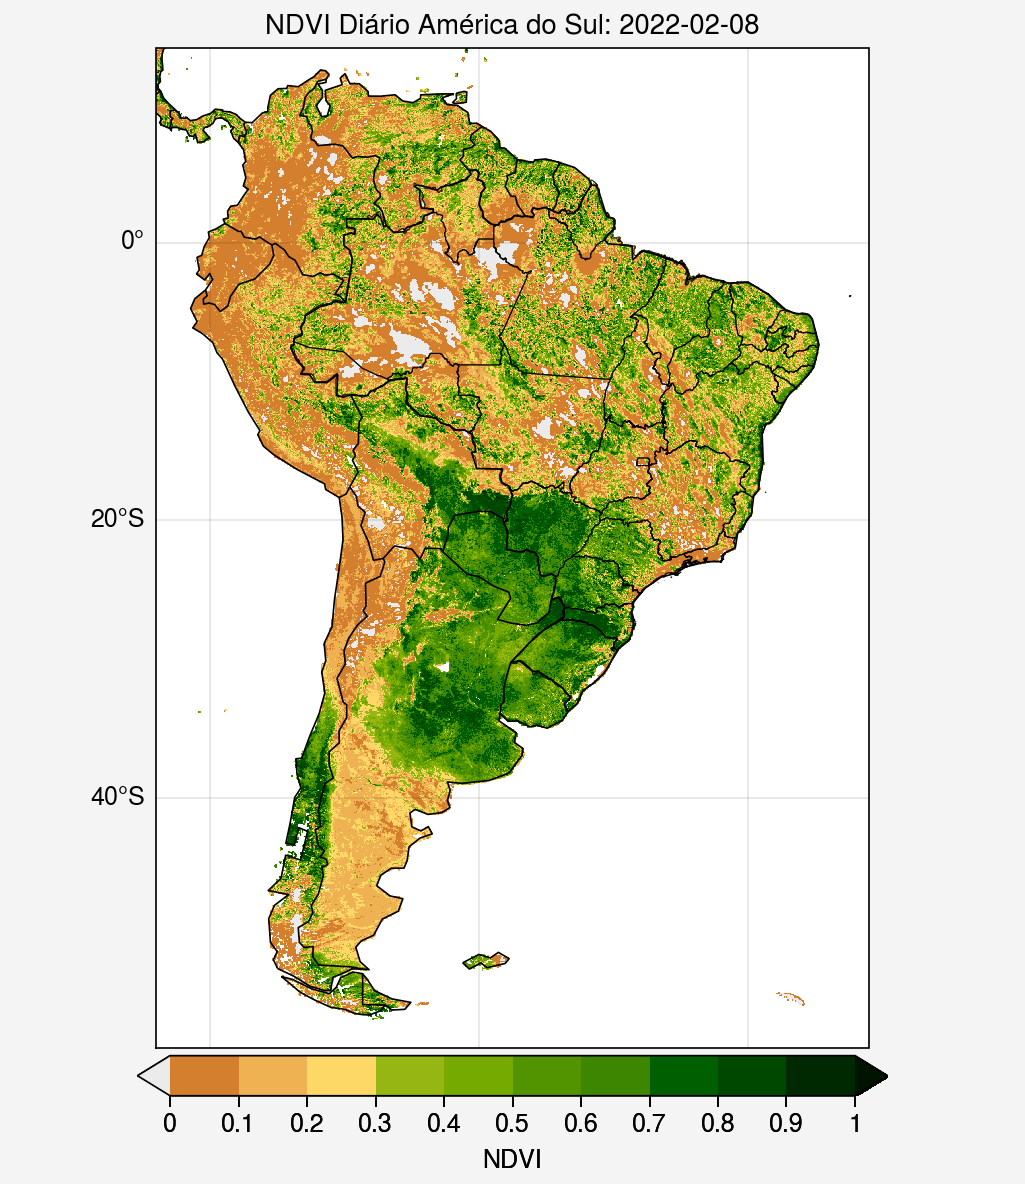

In [38]:
# define moldura da figura
fig, ax = plot.subplots(axwidth=5, axheight=5, tight=True, proj='pcarree')

# configuração dos eixos
ax.format(coast=True, borders=True, innerborders=False,
          labels=True, latlines=20, lonlines=20,
          latlim = (int(ndvi_dia_rec.latitude[0]), int(ndvi_dia_rec.latitude[-1])),
          lonlim = (int(ndvi_dia_rec.longitude[0]), int(ndvi_dia_rec.longitude[-1])),
          title=f'NDVI Diário América do Sul: {ano}-{mes}-{dia}')

# plota figura
map1 = ax.pcolormesh(ndvi_dia_rec['longitude'],
                     ndvi_dia_rec['latitude'],
                     ndvi_dia_rec[:,:],
                     vmin=vmin_ndvi,
                     vmax=vmax_ndvi,
                     cmap=cpt_convert_ndvi,
                     levels=plot.arange(vmin_ndvi, vmax_ndvi, 0.1),
                     extend='both')

# plota contornos dos Estados
estados.plot(edgecolor='black', facecolor='none', linewidth=0.4, alpha=0.8, ax=ax)

# plota barra de cores
fig.colorbar(map1, loc='b', label='NDVI', space=0.3, length=0.75)

# salva figura
fig.save(f'{dir}output/Fig_2_ndvi_SA_diario_{ano}{mes}{dia}.jpg', dpi=300, bbox_inches='tight')

# **PARTE 5):** Plotando NDVI `MENSAL`
- Nesta etapa iremos gerar um mapa mensal máximo de NDVI. Para isto precisaremos informar qual mês gostaríamos de analisar. Para esta análise usaremos como exemplo o mês de **fevereiro**.

**Informando o mês dos dados:** - **### >>> MUDANÇAS AQUI <<< ###**

In [39]:
mes = '02'

**Fazendo a média mensal do NDVI**

In [40]:
# calcula o valor máximo daquele mês
ndvi_mes = ndvi['NDVI'].resample(time='1M').max()

In [41]:
# mostra os tempos disponiveis
ndvi_mes['time']

<xarray.DataArray 'time' (time: 12)>
array(['2022-01-31T00:00:00.000000000', '2022-02-28T00:00:00.000000000',
       '2022-03-31T00:00:00.000000000', '2022-04-30T00:00:00.000000000',
       '2022-05-31T00:00:00.000000000', '2022-06-30T00:00:00.000000000',
       '2022-07-31T00:00:00.000000000', '2022-08-31T00:00:00.000000000',
       '2022-09-30T00:00:00.000000000', '2022-10-31T00:00:00.000000000',
       '2022-11-30T00:00:00.000000000', '2022-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2022-01-31 2022-02-28 ... 2022-12-31
Attributes:
    long_name:      time
    axis:           T
    standard_name:  time

**Transforma o mês de caracter para inteiro**

In [42]:
mesx = int(mes)

## **a) plotando figura `MENSAL` global**

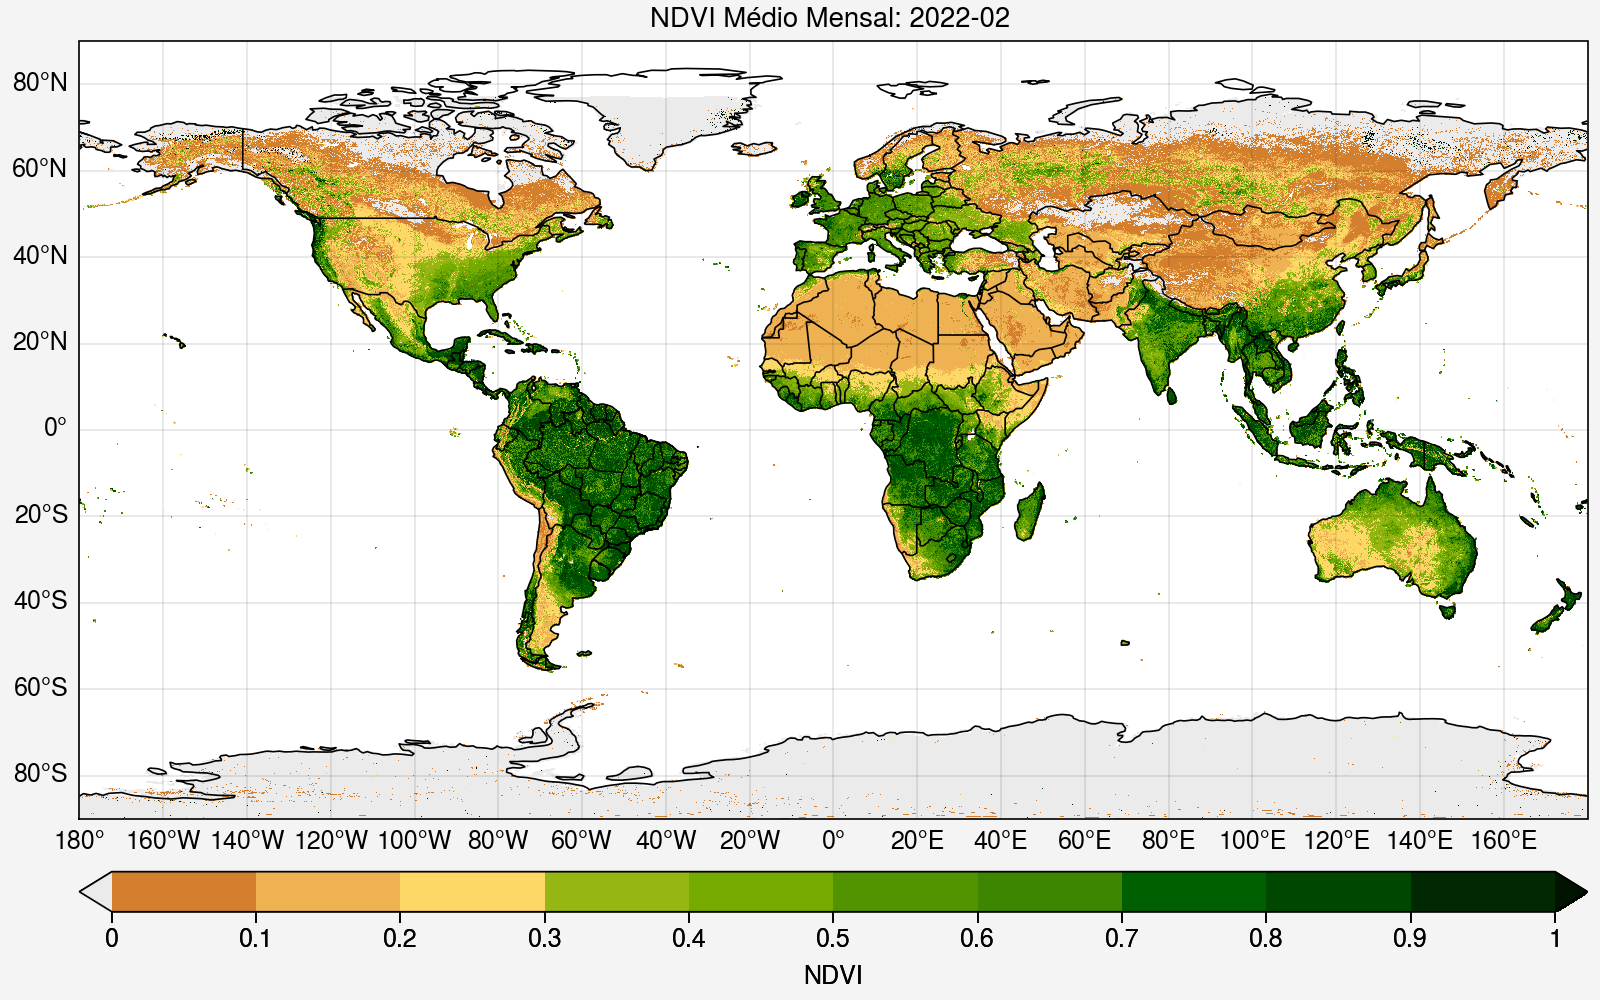

In [43]:
# cria moldura da figura
fig, ax = plot.subplots(figsize=(8, 5), tight=True, proj='pcarree')

# configuração dos eixos
ax.format(coast=True, borders=True, innerborders=False,
          labels=True,
          latlines=20, lonlines=20,
          title=f'NDVI Médio Mensal: {ano}-{mes} ')

# plota figura
map1 = ax.pcolormesh(ndvi_mes['longitude'],
                     ndvi_mes['latitude'],
                     ndvi_mes[mesx-1,:,:],
                     vmin=vmin_ndvi,
                     vmax=vmax_ndvi,
                     cmap=cpt_convert_ndvi,
                     levels=plot.arange(vmin_ndvi, vmax_ndvi, 0.1),
                     extend='both')

# plota contornos dos Estados
estados.plot(edgecolor='black', facecolor='none', linewidth=0.4, alpha=0.8, ax=ax)

# plota barra de cores
fig.colorbar(map1, loc='b', label='NDVI')

plot.show()

# salva figura
fig.save(f'{dir}output/Fig_3_ndvi_global_mensal_{ano}{mes}.jpg', dpi=300, bbox_inches='tight')

## **b) plotando figura `MENSAL` setorizada**

**selecionando a região**

In [44]:
ndvi_mes_rec = ndvi_mes.sel(longitude=slice(lonmin_AS, lonmax_AS), latitude=slice(latmax_AS, latmin_AS))

**exibindo o dado**

In [45]:
ndvi_mes_rec

<xarray.DataArray 'NDVI' (time: 12, latitude: 1480, longitude: 1080)>
dask.array<getitem, shape=(12, 1480, 1080), dtype=float32, chunksize=(1, 1480, 1080), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 14.97 14.92 14.88 ... -58.88 -58.93 -58.97
  * longitude  (longitude) float32 -84.97 -84.92 -84.88 ... -31.12 -31.07 -31.03
  * time       (time) datetime64[ns] 2022-01-31 2022-02-28 ... 2022-12-31
Attributes:
    long_name:      NOAA Climate Data Record of Normalized Difference Vegetat...
    units:          1
    valid_range:    [-1000 10000]
    grid_mapping:   crs
    standard_name:  normalized_difference_vegetation_index

**plotando a figura**

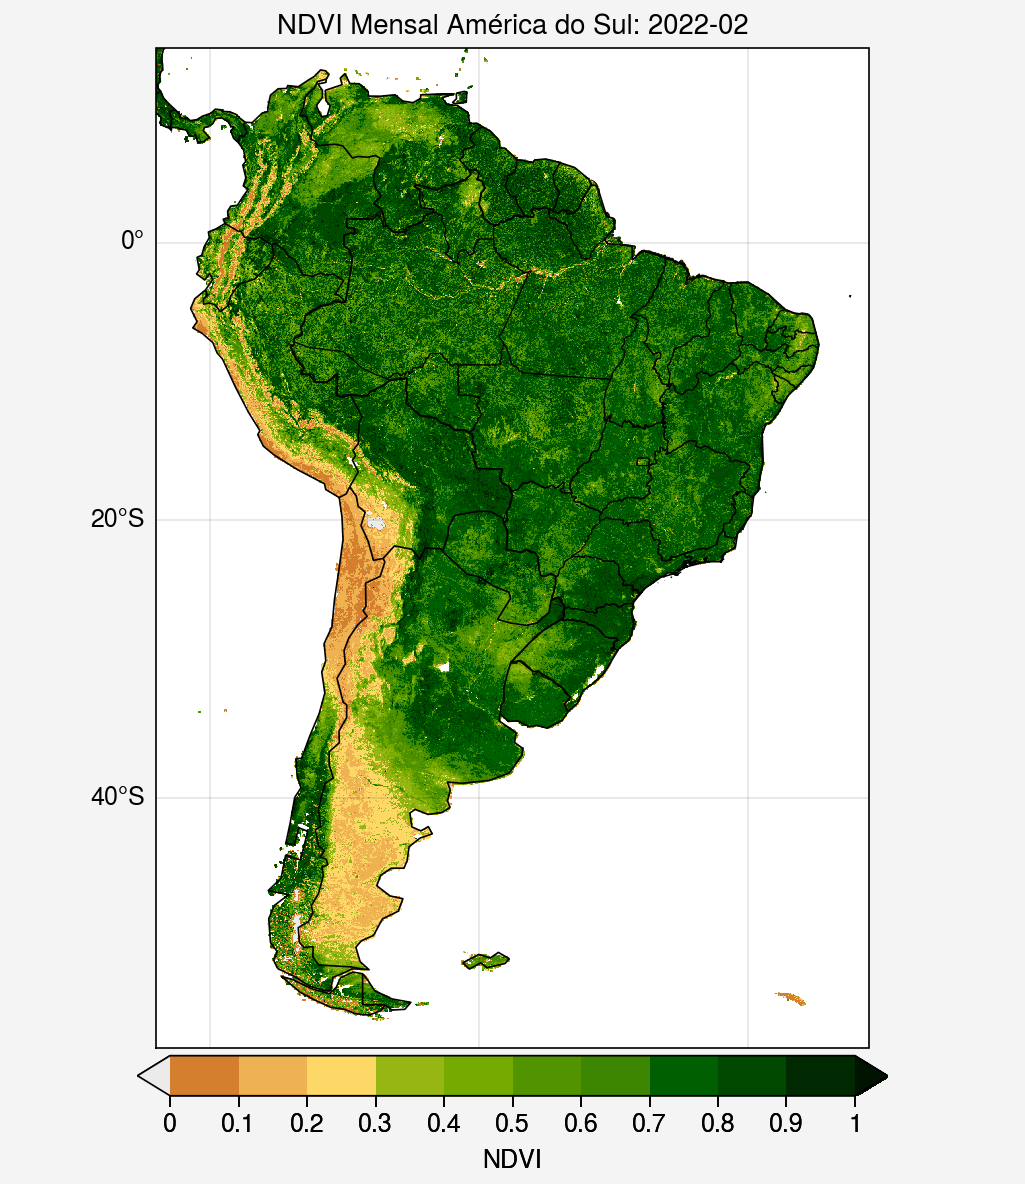

In [46]:
# define moldura da figura
fig, ax = plot.subplots(axwidth=5, axheight=5, tight=True, proj='pcarree')

# configuração dos eixos
ax.format(coast=True, borders=True, innerborders=False,
          labels=True,
          latlines=20, lonlines=20,
          latlim = (int(ndvi_mes_rec.latitude[0]), int(ndvi_mes_rec.latitude[-1])),
          lonlim = (int(ndvi_mes_rec.longitude[0]), int(ndvi_mes_rec.longitude[-1])),
          title=f'NDVI Mensal América do Sul: {ano}-{mes}')

# plota figura
map1 = ax.pcolormesh(ndvi_mes_rec['longitude'],
                     ndvi_mes_rec['latitude'],
                     ndvi_mes_rec[mesx-1,:,:],
                     vmin=vmin_ndvi,
                     vmax=vmax_ndvi,
                     cmap=cpt_convert_ndvi,
                     levels=plot.arange(vmin_ndvi, vmax_ndvi, 0.1),
                     extend='both')

# plota contornos dos Estados
estados.plot(edgecolor='black', facecolor='none', linewidth=0.4, alpha=0.8, ax=ax)

# plota barra de cores
fig.colorbar(map1, loc='b', label='NDVI', space=0.3, length=0.75)

# salva figura
fig.save(f'{dir}output/Fig_4_ndvi_SA_mensal_{ano}{mes}.jpg', dpi=300, bbox_inches='tight')

# **PARTE 6):** Plotando NDVI `ANUAL`

**agrupando os dados para um ano e calculando o valor máximo**

In [47]:
ndvi_ano = ndvi['NDVI'].resample(time='1Y').max()

**exibindo na tela o dado**

In [48]:
ndvi_ano

<xarray.DataArray 'NDVI' (time: 1, latitude: 3600, longitude: 7200)>
dask.array<stack, shape=(1, 3600, 7200), dtype=float32, chunksize=(1, 3600, 7200), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 89.97 89.93 89.88 ... -89.88 -89.93 -89.97
  * longitude  (longitude) float32 -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
  * time       (time) datetime64[ns] 2022-12-31
Attributes:
    long_name:      NOAA Climate Data Record of Normalized Difference Vegetat...
    units:          1
    valid_range:    [-1000 10000]
    grid_mapping:   crs
    standard_name:  normalized_difference_vegetation_index

## **a) plotando figura `ANUAL` global**

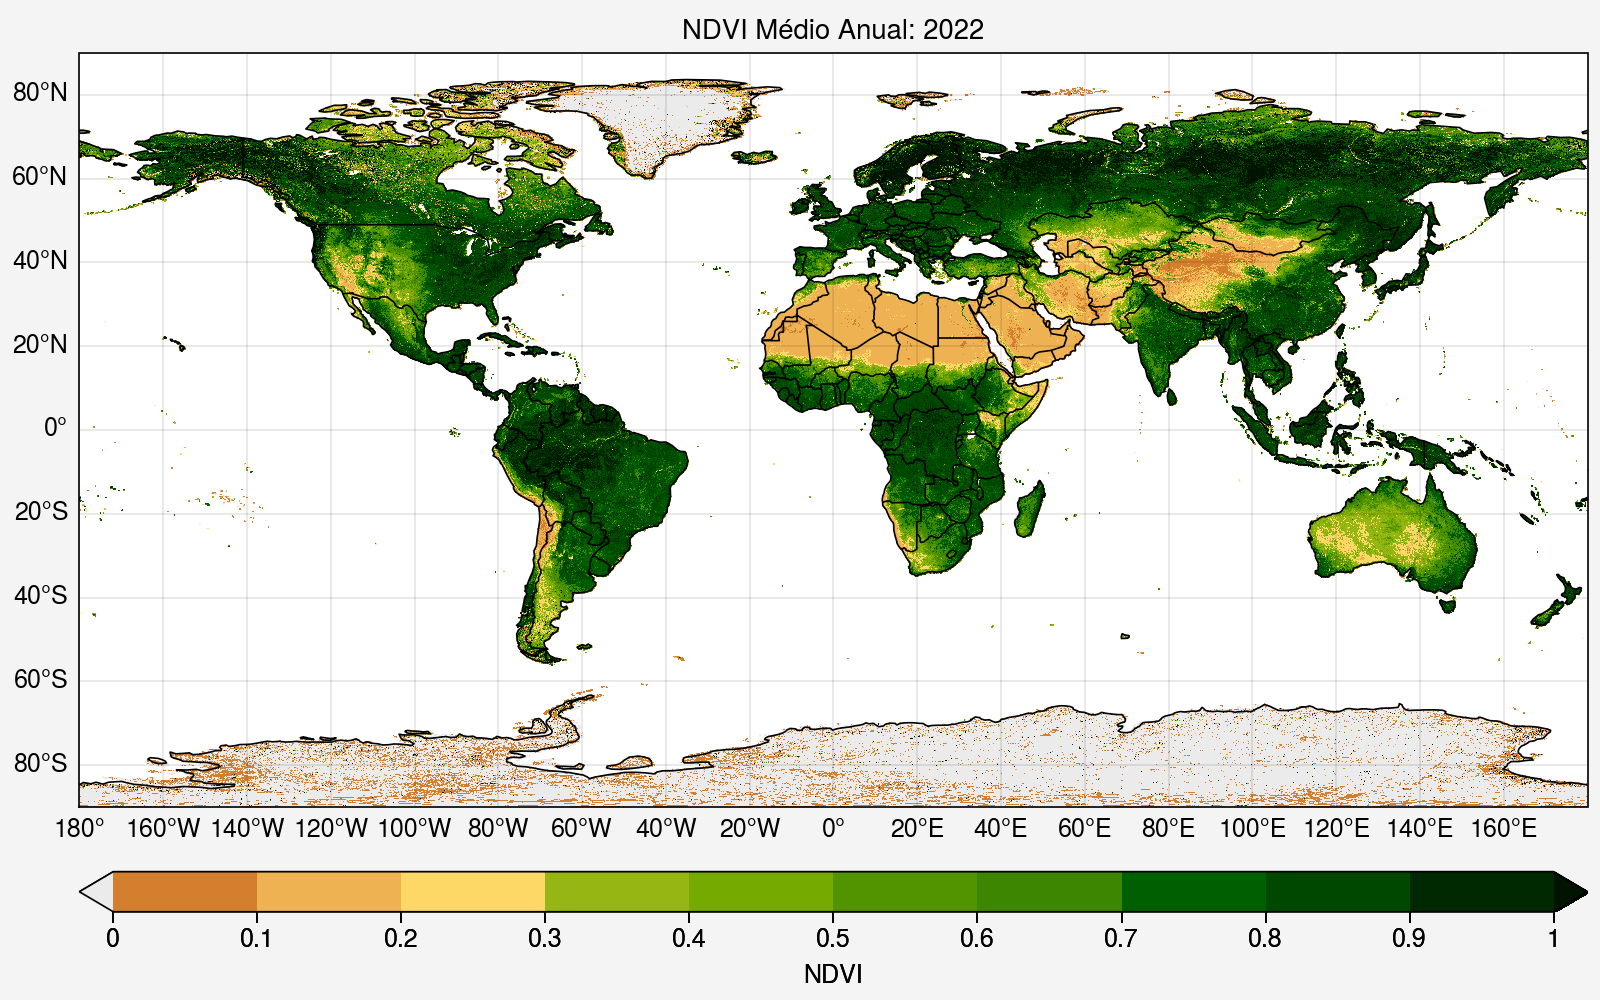

In [49]:
# moldura da figura
fig, ax = plot.subplots(figsize=(8, 5), tight=True, proj='pcarree')

# formatação dos eixos
ax.format(coast=True, borders=True, innerborders=False,
          labels=True,
          latlines=20, lonlines=20,
          title=f'NDVI Médio Anual: {ano}')

# plota figura
map1 = ax.pcolormesh(ndvi_ano['longitude'],
                     ndvi_ano['latitude'],
                     ndvi_ano[0,:,:],
                     vmin=vmin_ndvi,
                     vmax=vmax_ndvi,
                     cmap=cpt_convert_ndvi,
                     levels=plot.arange(vmin_ndvi, vmax_ndvi, 0.1),
                     extend='both')

# plota barra de cores
fig.colorbar(map1, loc='b', label='NDVI')

# salva figura
fig.save(f'{dir}output/Fig_5_ndvi_global_anual_{ano}.jpg', dpi=300, bbox_inches='tight')

## **b) plotando figura `ANUAL` setorizada**

**fazendo o recorte no dado**

In [50]:
ndvi_ano_rec = ndvi_ano.sel(longitude=slice(lonmin_AS, lonmax_AS), latitude=slice(latmax_AS, latmin_AS))
ndvi_ano_rec

<xarray.DataArray 'NDVI' (time: 1, latitude: 1480, longitude: 1080)>
dask.array<getitem, shape=(1, 1480, 1080), dtype=float32, chunksize=(1, 1480, 1080), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 14.97 14.92 14.88 ... -58.88 -58.93 -58.97
  * longitude  (longitude) float32 -84.97 -84.92 -84.88 ... -31.12 -31.07 -31.03
  * time       (time) datetime64[ns] 2022-12-31
Attributes:
    long_name:      NOAA Climate Data Record of Normalized Difference Vegetat...
    units:          1
    valid_range:    [-1000 10000]
    grid_mapping:   crs
    standard_name:  normalized_difference_vegetation_index

**plotando a figura**

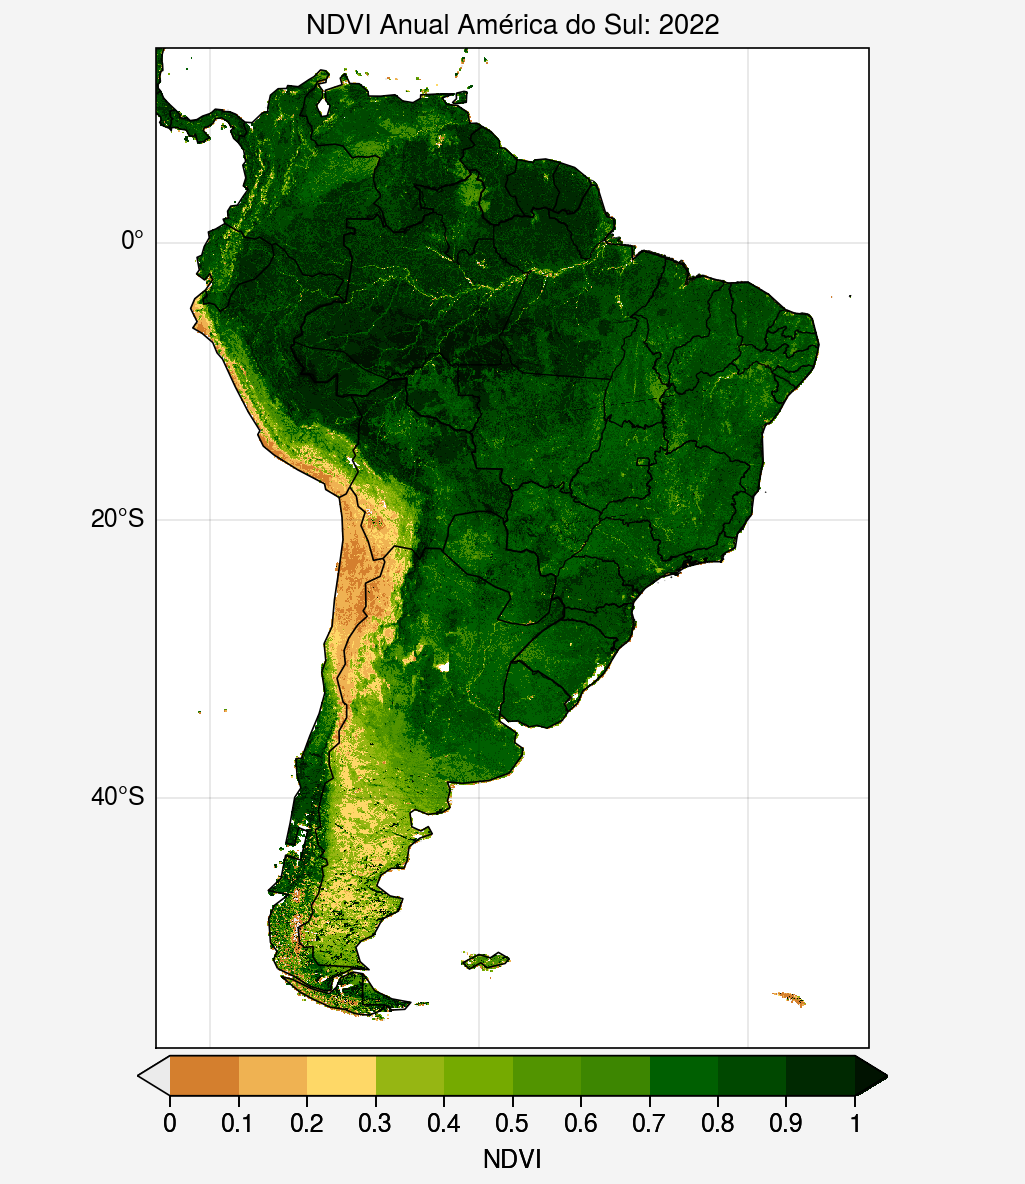

In [51]:
# define moldura da figura
fig, ax = plot.subplots(axwidth=5, axheight=5, tight=True, proj='pcarree')

# formatação dos eixos
ax.format(coast=True, borders=True, innerborders=False,
          labels=True,
          latlines=20, lonlines=20,
          latlim = (int(ndvi_ano_rec.latitude[0]), int(ndvi_ano_rec.latitude[-1])),
          lonlim = (int(ndvi_ano_rec.longitude[0]), int(ndvi_ano_rec.longitude[-1])),
          title=f'NDVI Anual América do Sul: {ano}')

# plota figura
map1 = ax.pcolormesh(ndvi_ano_rec['longitude'],
                     ndvi_ano_rec['latitude'],
                     ndvi_ano_rec[0,:,:],
                     vmin=vmin_ndvi,
                     vmax=vmax_ndvi,
                     cmap=cpt_convert_ndvi,
                     levels=plot.arange(vmin_ndvi, vmax_ndvi, 0.1),
                     extend='both')

# plota contornos dos Estados
estados.plot(edgecolor='black', facecolor='none', linewidth=0.4, alpha=0.8, ax=ax)

# plota barra de cores
fig.colorbar(map1, loc='b', label='NDVI', space=0.3, length=0.75)

# salva figura
fig.save(f'{dir}output/Fig_6_ndvi_SA_anual_{ano}.jpg', dpi=300, bbox_inches='tight')